Data Loading Phase

In [ ]:
!pip install pandas

In [ ]:
!pip install numpy

In [21]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.3 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/8.1 MB 1.3 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/8.1 MB 932.9 kB/s eta 0:00:08
   --- ------------------------------------ 0.8/8.1 MB 932.9 kB/s eta 0:00:08
   ----- ---------------------------------- 1.0/8.1 MB 839.3 kB/s eta 0:00:09
   ------ --------------------------------- 1.3/8.1 MB 871.6 kB/s eta 0:00:08
   ------- -------------------------------- 1.6/8.1 MB 883.2 kB/s eta 0:00:08
   ------- -------------------------------- 1.6/8.1 MB 883.2 kB/s eta 0:00:08
   --------- ------------------------------ 1.8/8.1 MB 875.3 kB/s eta 0:00:08
   ---------- -----------------

DEPRECATION: Loading egg at c:\users\rayantech\programs\python\python312\lib\site-packages\argparse-1.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\rayantech\programs\python\python312\lib\site-packages\astor-0.8.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\rayantech\programs\python\python312\lib\site-packages\pyggi-2.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run:

In [ ]:
!pip install seaborn

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv("dataset.csv")
print(df.isna().sum())
print(df.head())

age         51
sex          0
cp           0
trestbps    51
chol        13
fbs          0
restecg      0
thalach     17
exang        0
oldpeak      1
slope        0
ca          51
thal        51
target       0
dtype: int64
    age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  52.0    1   0     125.0  212.0    0        1    168.0      0      1.0   
1  53.0    1   0     140.0  203.0    1        0    155.0      1      3.1   
2  70.0    1   0     145.0  174.0    0        1    125.0      1      2.6   
3  61.0    1   0     148.0  203.0    0        1    161.0      0      0.0   
4  62.0    0   0     138.0  294.0    1        1    106.0      0      1.9   

   slope   ca  thal  target  
0      2  2.0   3.0       0  
1      0  0.0   3.0       0  
2      0  0.0   3.0       0  
3      2  1.0   3.0       0  
4      1  NaN   NaN       0  


Handling Missing and Noisy Values

In [26]:
def knn_impute(df, k=3):
    df_imputed = df.copy()
    data = df.values
    
    for i in range(len(data)):
        row = data[i]
        if np.any(np.isnan(row)):
            distances = []
            for j in range(len(data)):
                if i == j:
                    continue
                other = data[j]
                mask = ~np.isnan(row) & ~np.isnan(other)
                if np.sum(mask) == 0:
                    continue
                dist = np.sqrt(np.sum((row[mask] - other[mask]) ** 2))
                distances.append((dist, j))

            distances.sort(key=lambda x: x[0])
            neighbors_idx = [j for _, j in distances[:k]]

            for col in range(data.shape[1]):
                if np.isnan(row[col]):
                    vals = [data[j, col] for j in neighbors_idx if not np.isnan(data[j, col])]
                    if vals:
                        df_imputed.iat[i, col] = np.mean(vals)
    return df_imputed

def knn_impute_weighted(df, k=3, epsilon=1e-5):
    df_imputed = df.copy()
    data = df.values
    
    for i in range(len(data)):
        row = data[i]
        if np.any(np.isnan(row)):
            distances = []
            for j in range(len(data)):
                if i == j:
                    continue
                other = data[j]
                mask = ~np.isnan(row) & ~np.isnan(other)
                if np.sum(mask) == 0:
                    continue
                dist = np.sqrt(np.sum((row[mask] - other[mask]) ** 2))
                distances.append((dist, j))
            
            # sort and select k nearest
            distances.sort(key=lambda x: x[0])
            neighbors = distances[:k]
            
            for col in range(data.shape[1]):
                if np.isnan(row[col]):
                    vals, weights = [], []
                    for dist, j in neighbors:
                        val = data[j, col]
                        if not np.isnan(val):
                            # inverse distance as weight (closer => higher weight)
                            w = 1.0 / (dist + epsilon)
                            vals.append(val)
                            weights.append(w)
                    if vals:
                        weighted_avg = np.average(vals, weights=weights)
                        df_imputed.iat[i, col] = weighted_avg
    return df_imputed


In [23]:
# df_imputed = knn_impute(df, k=3)
df_imputed = knn_impute_weighted(df, k=3)
print(df_imputed.isna().sum())
print(df_imputed)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
       age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     52.0    1   0     125.0  212.0    0        1    168.0      0      1.0   
1     53.0    1   0     140.0  203.0    1        0    155.0      1      3.1   
2     70.0    1   0     145.0  174.0    0        1    125.0      1      2.6   
3     61.0    1   0     148.0  203.0    0        1    161.0      0      0.0   
4     62.0    0   0     138.0  294.0    1        1    106.0      0      1.9   
...    ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
1020  59.0    1   1     140.0  221.0    0        1    164.0      1      0.0   
1021  60.0    1   0     125.0  258.0    0        0    141.0      1      2.8   
1022  47.0    1   0     110.0  275.0    0        0    118.0      1      1.0   
1

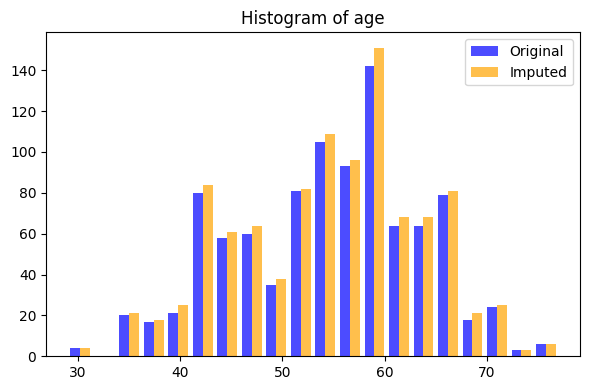

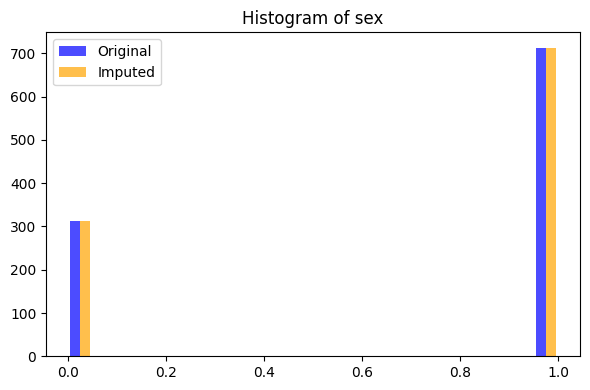

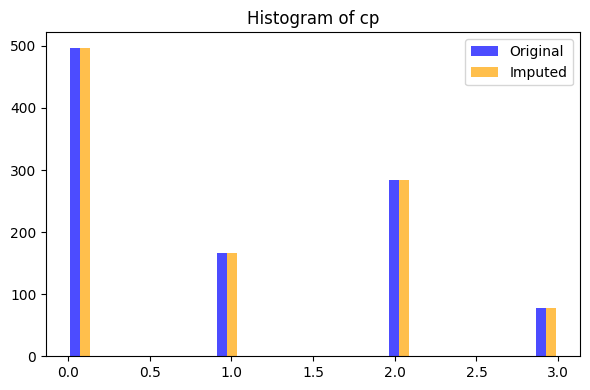

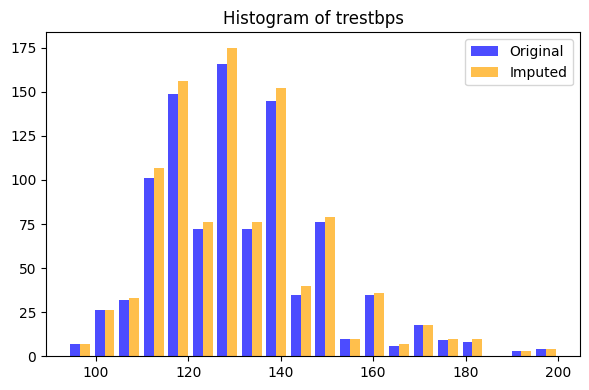

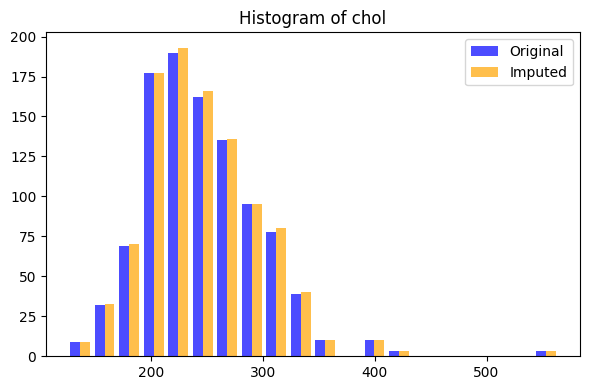

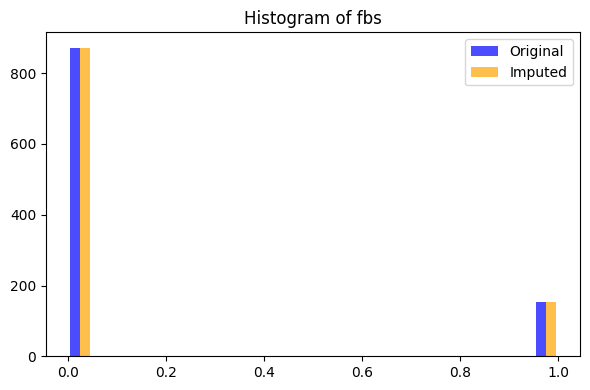

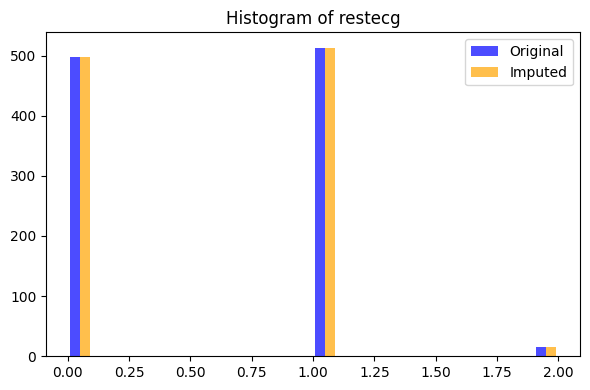

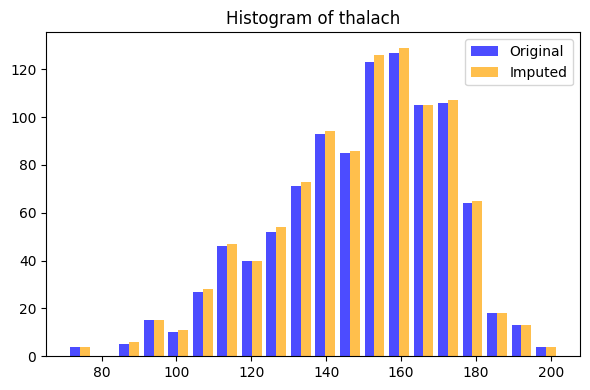

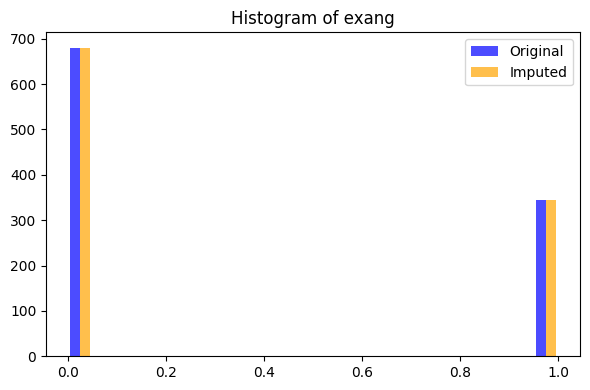

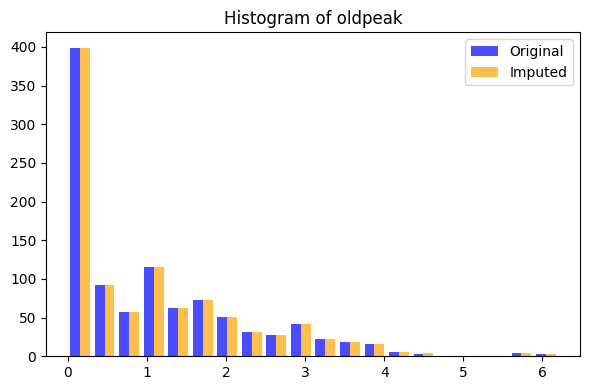

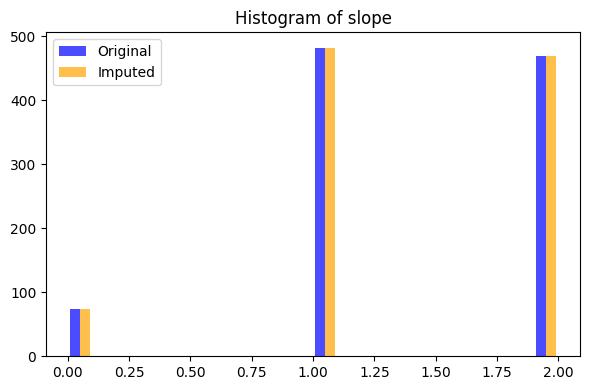

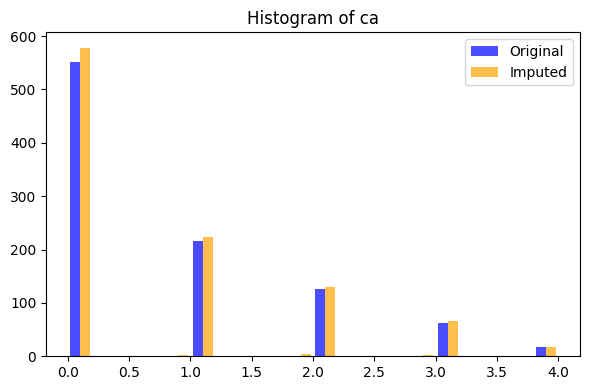

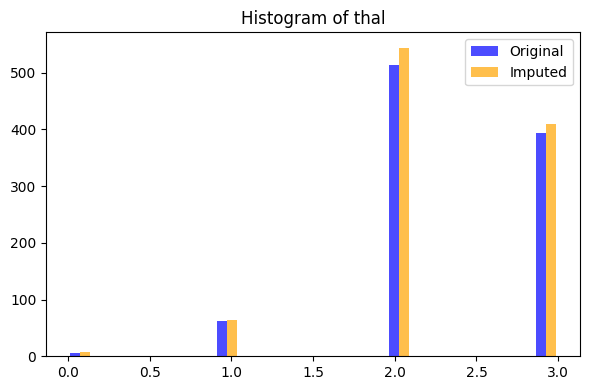

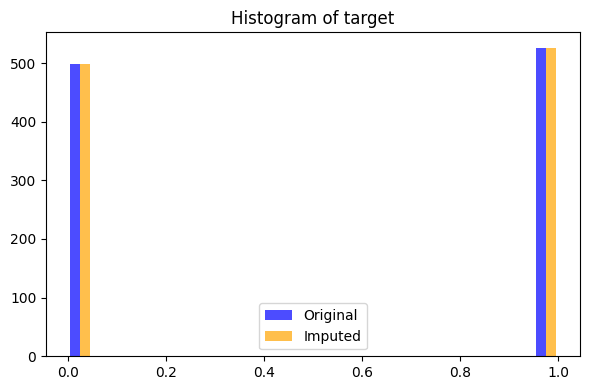

In [29]:
for col in df.columns:
    plt.figure(figsize=(6, 4))
    plt.hist([df[col].dropna(), df_imputed[col]],
             bins=20,
             label=['Original', 'Imputed'],
             color=['blue', 'orange'],
             alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Normalization

In [31]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
df_scaled[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()
print(df_scaled.describe())

                age           sex            cp      trestbps          chol  \
count  9.740000e+02  1.025000e+03  1.025000e+03  9.740000e+02  1.012000e+03   
mean  -2.954515e-16  9.011762e-17  6.932124e-17  8.024610e-17  6.494585e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.816922e+00 -1.510969e+00 -9.153086e-01 -2.140708e+00 -2.324132e+00   
25%   -7.157547e-01 -1.510969e+00 -9.153086e-01 -6.566871e-01 -6.771800e-01   
50%    1.689472e-01  6.611813e-01  5.590394e-02 -8.590963e-02 -1.152789e-01   
75%    7.218859e-01  6.611813e-01  1.027116e+00  4.848678e-01  5.628776e-01   
max    2.491290e+00  6.611813e-01  1.998329e+00  3.909533e+00  6.162513e+00   

                fbs       restecg       thalach         exang       oldpeak  \
count  1.025000e+03  1.025000e+03  1.008000e+03  1.025000e+03  1.024000e+03   
mean   6.238912e-17 -4.159275e-17  5.603983e-16 -1.299773e-16 -1.196959e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.

Exploratory Data Analysis (EDA)

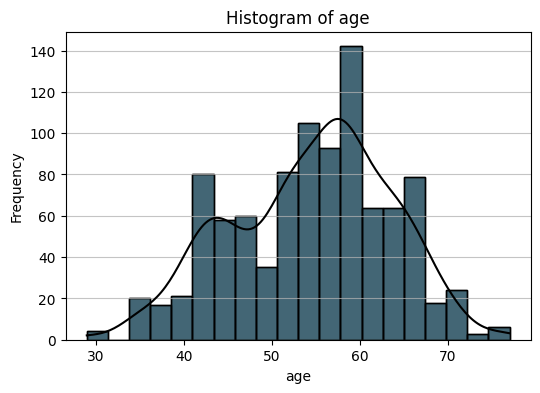

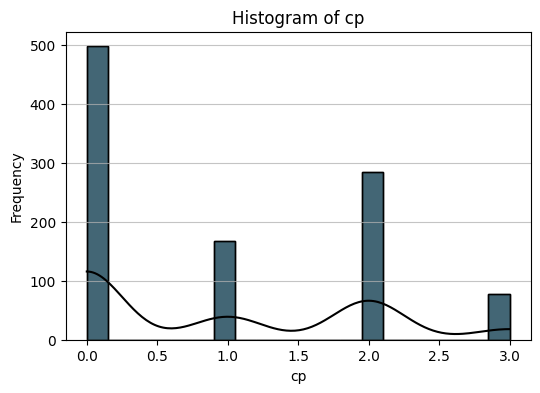

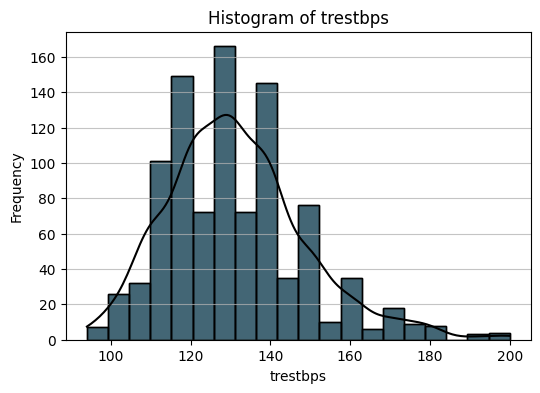

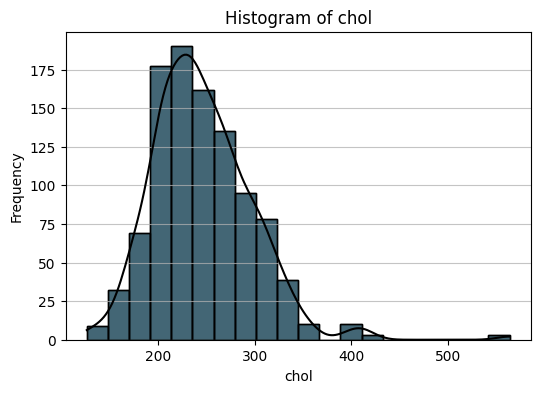

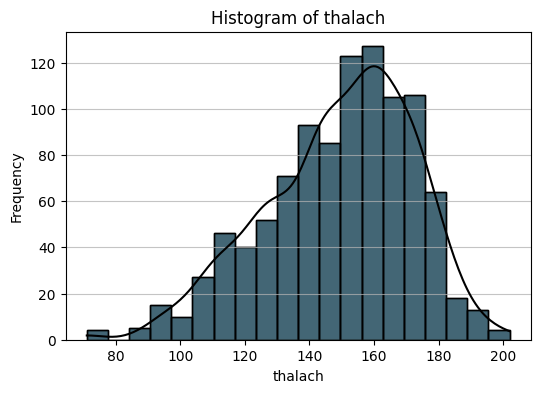

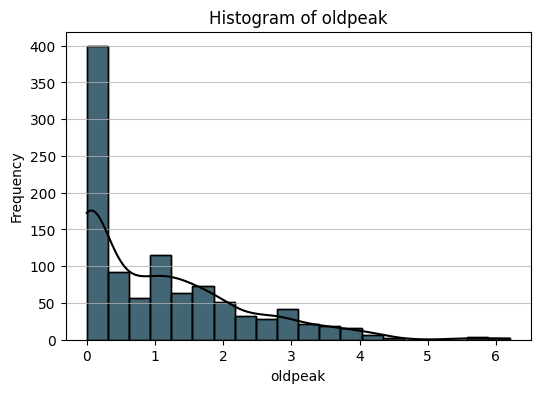

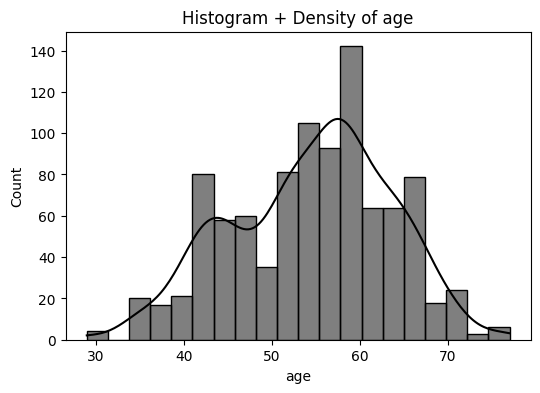

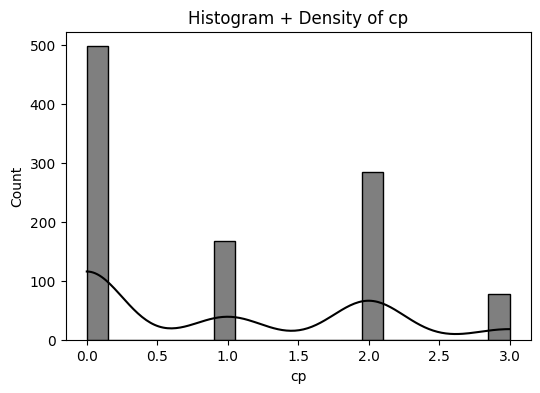

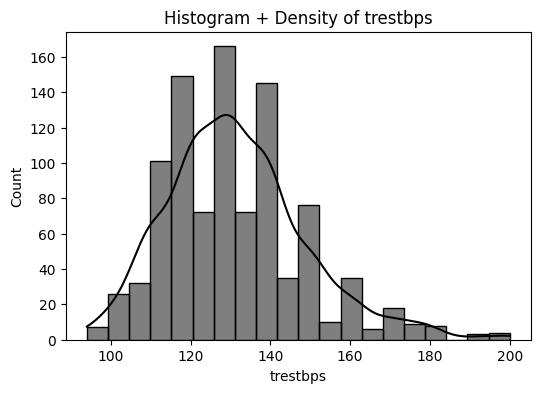

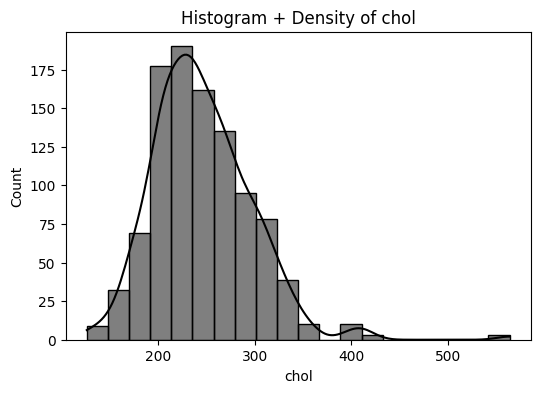

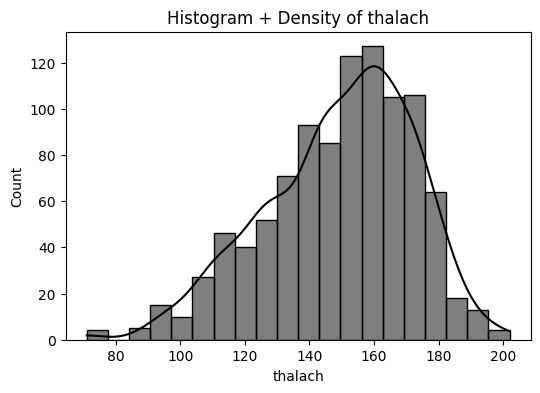

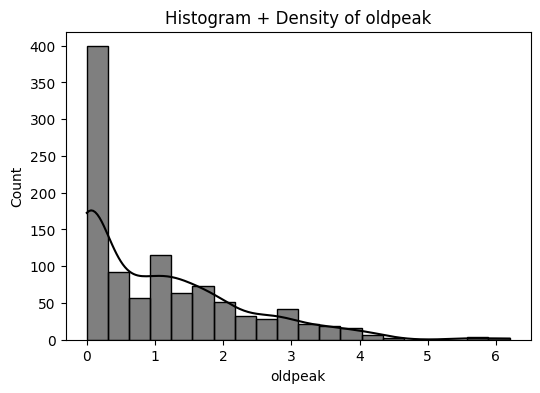

In [39]:

exclude_cols = ['target', 'exang', 'fbs', 'sex', 'slope', 'ca', 'thal', 'restecg']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    sns.histplot(df[col].dropna(), bins=20, kde=True, color='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=20, kde=True, color='black')
    plt.title(f'Histogram + Density of {col}')
    plt.show()

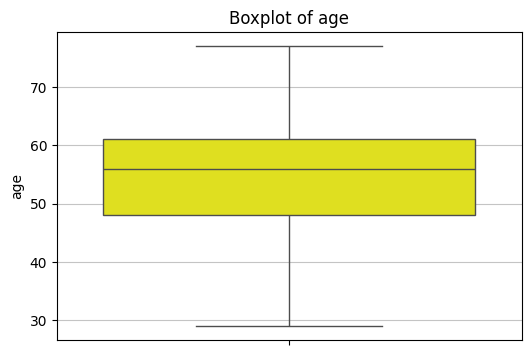

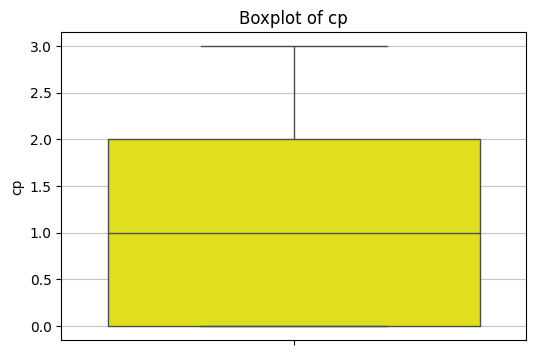

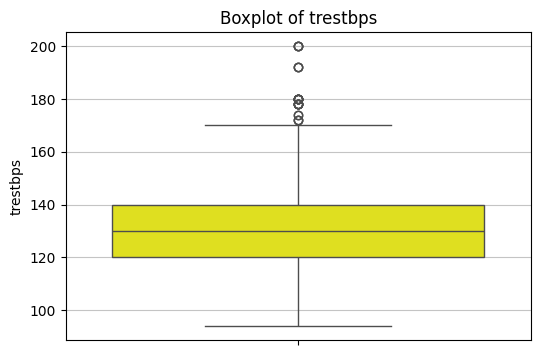

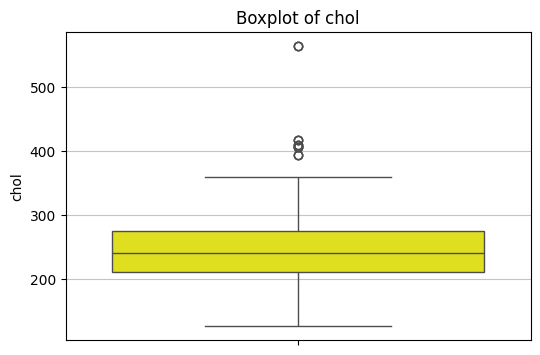

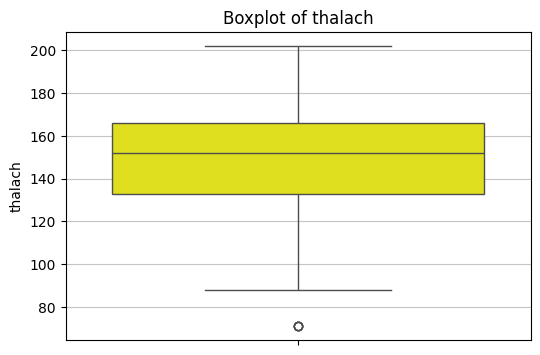

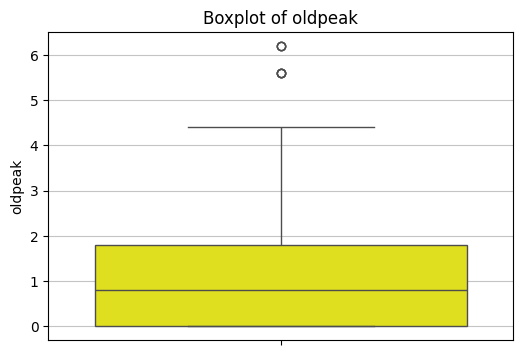

In [40]:
exclude_cols = ['target', 'exang', 'fbs', 'sex', 'slope', 'ca', 'thal', 'restecg']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col], color='yellow')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

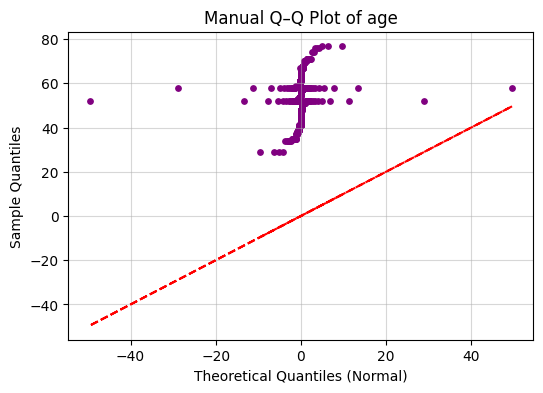

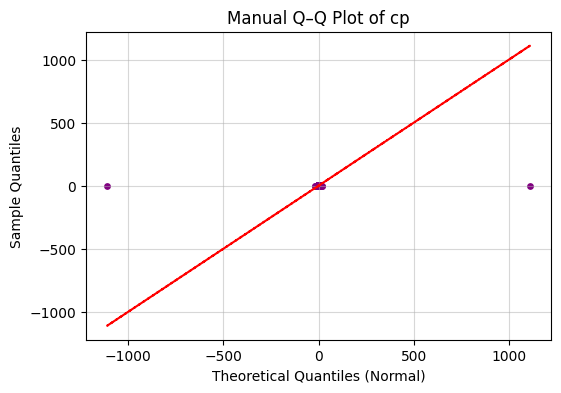

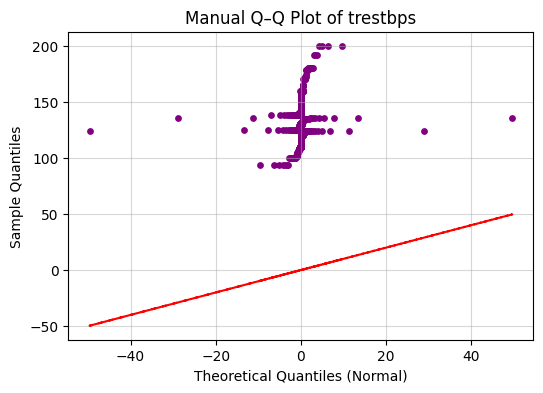

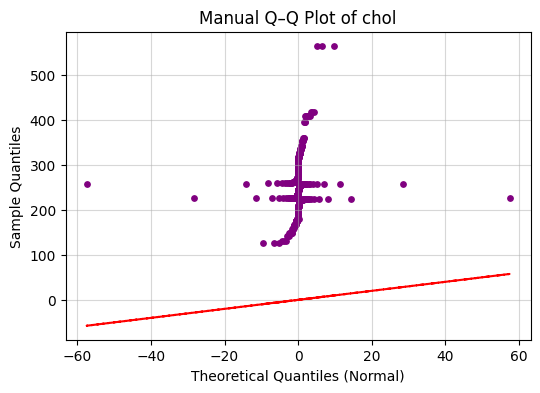

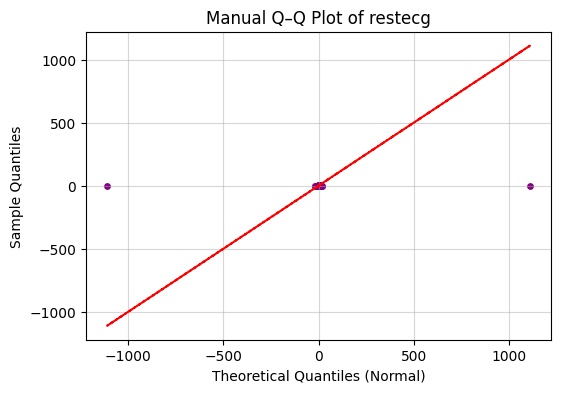

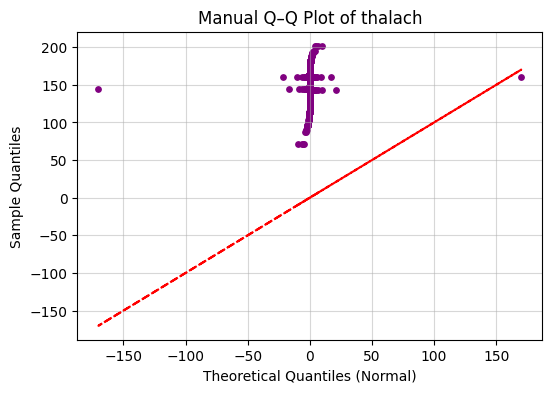

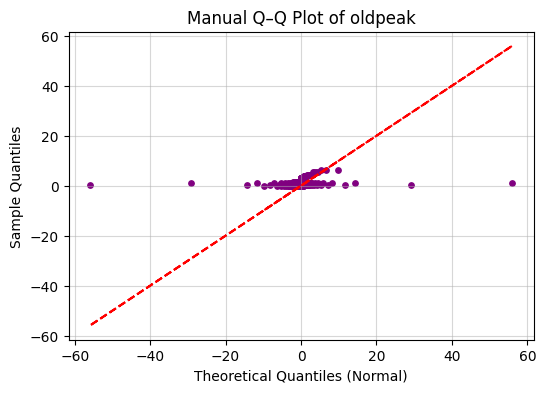

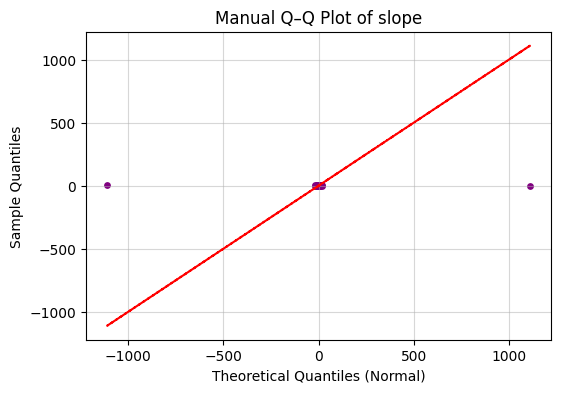

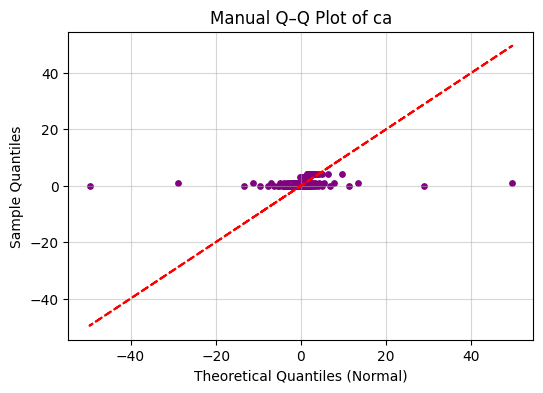

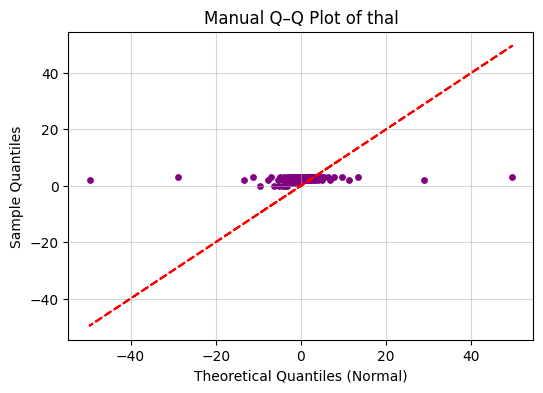

What to show for QQ???

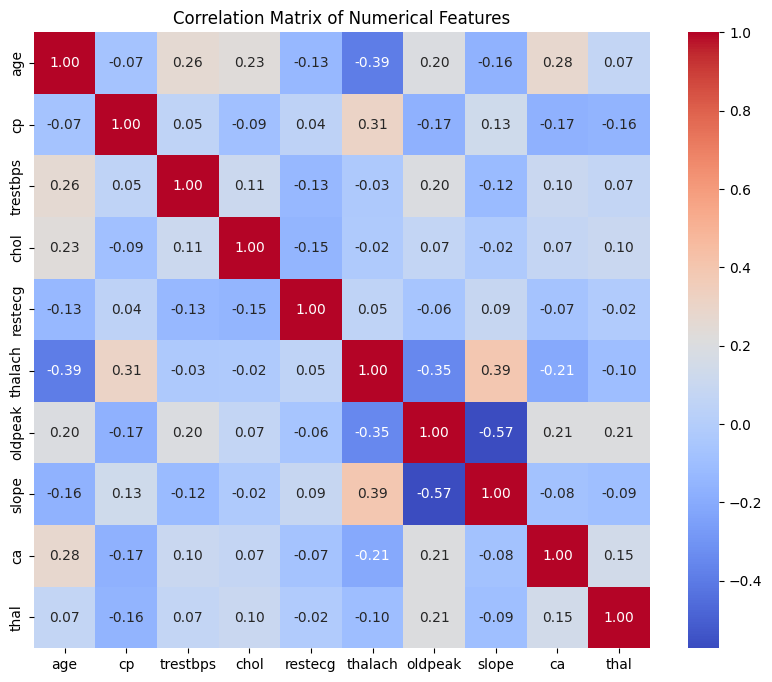

In [44]:
exclude_cols = ['target', 'exang', 'fbs', 'sex']

numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                if col not in exclude_cols]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Most features are reasonably independent, which is good for KNN — each contributes differently to distance calculations.

Train and Test the Model

In [45]:
X = df.drop('target', axis=1).to_numpy()
y = df['target'].to_numpy()

np.random.seed(42)
indices = np.arange(len(df))
np.random.shuffle(indices)

train_size = int(0.8 * len(df))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 820
Test size: 205


In [47]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict_weighted(X_train, y_train, X_test, k=5):
    y_pred = []
    for test_point in X_test:
        distances = np.array([euclidean_distance(test_point, x) for x in X_train])
        nn_indices = distances.argsort()[:k]
        nn_labels = y_train[nn_indices]
        nn_distances = distances[nn_indices]
        # weight = 1 / distance (avoid div by 0)
        weights = 1 / (nn_distances + 1e-5)
        # vote with weights
        label_weights = {}
        for label, w in zip(nn_labels, weights):
            label_weights[label] = label_weights.get(label, 0) + w
        y_pred.append(max(label_weights, key=label_weights.get))
    return np.array(y_pred)

best_k = 1
best_acc = 0
for k in range(1, 21, 2):  # odd numbers to avoid ties
    y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k)
    acc = np.mean(y_pred == y_test)
    print(f"k={k}, accuracy={acc:.3f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k
print("Best k:", best_k, "with accuracy:", best_acc)


k=1, accuracy=0.844
k=3, accuracy=0.844
k=5, accuracy=0.839
k=7, accuracy=0.844
k=9, accuracy=0.844
k=11, accuracy=0.834
k=13, accuracy=0.834
k=15, accuracy=0.834
k=17, accuracy=0.834
k=19, accuracy=0.834
Best k: 1 with accuracy: 0.8439024390243902


In [50]:

def compute_metrics(y_true, y_pred):
    """
    Works for binary classification (labels 0 and 1)
    Returns accuracy, precision, recall, f1-score
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return accuracy, precision, recall, f1

rows = []
for k in range(1, 21, 2):
    y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    rows.append({
        'k': k,
        'Accuracy': round(acc, 3),
        'Precision': round(prec, 3),
        'Recall': round(rec, 3),
        'F1-score': round(f1, 3)
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

    k  Accuracy  Precision  Recall  F1-score
0   1     0.844      0.785   0.962     0.864
1   3     0.844      0.785   0.962     0.864
2   5     0.839      0.783   0.953     0.860
3   7     0.844      0.785   0.962     0.864
4   9     0.844      0.785   0.962     0.864
5  11     0.834      0.781   0.943     0.855
6  13     0.834      0.781   0.943     0.855
7  15     0.834      0.781   0.943     0.855
8  17     0.834      0.781   0.943     0.855
9  19     0.834      0.781   0.943     0.855


Apply K-Fold Cross-Validation

In [52]:
def k_fold_cross_validation(X, y, k_neighbors=5, n_splits=5, weighted=True):
    """
    Perform K-Fold CV for KNN
    X: features (numpy array)
    y: labels (numpy array)
    k_neighbors: number of neighbors for KNN
    n_splits: number of folds
    weighted: whether to use weighted KNN
    Returns: average metrics across folds
    """
    fold_size = len(X) // n_splits
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    accuracies, precisions, recalls, f1s = [], [], [], []

    for i in range(n_splits):
        test_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.setdiff1d(indices, test_idx)
        
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        if weighted:
            y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k_neighbors)
        else:
            y_pred = knn_predict_weighted(X_train, y_train, X_test, k=k_neighbors)

        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    return {
        'Accuracy': np.mean(accuracies),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1-score': np.mean(f1s)
    }

k_values = range(1, 21, 2)
rows = []

for k in k_values:
    metrics = k_fold_cross_validation(X_train, y_train, k_neighbors=k, n_splits=5)
    rows.append({
        'k': k,
        'Accuracy': round(metrics['Accuracy'], 3),
        'Precision': round(metrics['Precision'], 3),
        'Recall': round(metrics['Recall'], 3),
        'F1-score': round(metrics['F1-score'], 3)
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

    k  Accuracy  Precision  Recall  F1-score
0   1     0.861      0.810   0.954     0.875
1   3     0.879      0.829   0.964     0.891
2   5     0.868      0.822   0.953     0.881
3   7     0.865      0.820   0.943     0.877
4   9     0.877      0.826   0.964     0.888
5  11     0.878      0.839   0.943     0.887
6  13     0.871      0.853   0.912     0.877
7  15     0.877      0.846   0.927     0.884
8  17     0.876      0.836   0.945     0.886
9  19     0.872      0.830   0.945     0.883


Elbow Method

k=1, CV Error=0.105
k=3, CV Error=0.110
k=5, CV Error=0.098
k=7, CV Error=0.106
k=9, CV Error=0.093
k=11, CV Error=0.101
k=13, CV Error=0.104
k=15, CV Error=0.105
k=17, CV Error=0.111
k=19, CV Error=0.100


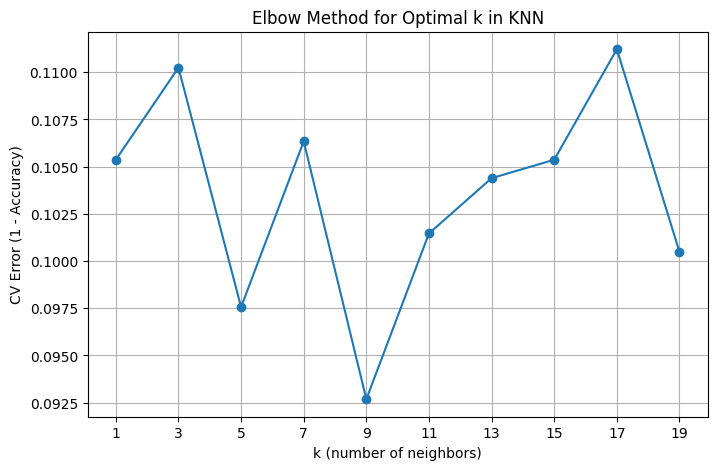

In [53]:
def knn_error_for_k(X, y, k_values, n_splits=5, weighted=True):
    errors = []
    for k in k_values:
        metrics = k_fold_cross_validation(X, y, k_neighbors=k, n_splits=n_splits, weighted=weighted)
        error = 1 - metrics['Accuracy']  # error rate
        errors.append(error)
        print(f"k={k}, CV Error={error:.3f}")
    return errors

k_values = range(1, 21, 2)
cv_errors = knn_error_for_k(X, y, k_values, n_splits=5)

plt.figure(figsize=(8,5))
plt.plot(k_values, cv_errors, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('CV Error (1 - Accuracy)')
plt.title('Elbow Method for Optimal k in KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()